In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display


# Options

### to add
1. option for emissions to be evenly spread, mimic existing spread, or exact input
2. radiation vs. surface level output

In [11]:
region = {'SEA':'Southeast Asia'}
month = 'Apr' #options are Jan, Apr, Jul, Oct
time = '201604*'
compare_2x = False #True allows for comparison to the 2x simulation to see the performance of the GF; False just creates a new GF
global_mean = True #False turns on a spatially explicit version with lat and lon; True turns on a global weighted mean
length_simulation = 60 #days
RRTMG = False
concentration = True

if RRTMG == True:
    diagnostic = 'RRTMG'
if concentration == True:
    diagnostic = 'SpeciesConc'
if RRTMG and concentration == True:
    print('WARNING: Must choose between radiation (RRTMG) and black carbon concentration (concentration) above')

## Import data

In [8]:
ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_pulse/{list(region.keys())[0]}/{month}/mod_output/GEOSChem.SpeciesConc.{time}', combine = 'by_coords')
ds_emisdelta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_pulse/{list(region.keys())[0]}/{month}/mod_output/GEOSChem.Emissions.{time}', combine = 'by_coords')

ds_base = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_base/template/mod_output/GEOSChem.SpeciesConc.{time}', combine = 'by_coords', engine = 'netcdf4')
ds_emisbase = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_base/template/mod_output/GEOSChem.Emissions.{time}', combine = 'by_coords', engine = 'netcdf4')

In [12]:
def fix_area_ij_latlon(ds):
    ds_area = ds['area']
    ds_area = ds_area.rename({'i':'lat','j':'lon'})
    ds_area['i']= ds['lat']
    ds_area['j'] = ds['lon']
    ds['area'] = ds_area.drop(['j','i'])
    return(ds)

In [13]:
if compare_2x == True:
    #import data
    #ds_emis2x = xr.open_dataset(f'../GCrundirs/IRF_runs/mod_inputs/BC-em-anthro_CMIP_CEDS_2016_{list(region.keys())[0]}_2x.nc')
    ds_emis2x = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_2x/{list(region.keys())[0]}/mod_output/GEOSChem.Emissions.{time}', combine = 'by_coords')
    ds_conc2x = xr.open_mfdataset(f'../GCrundirs/IRF_runs/RRTMG_2x/{list(region.keys())[0]}/mod_output/GEOSChem.SpeciesConc.{time}', combine = 'by_coords')
    
    #create one dataset
    ds_emis = xr.concat([ds_emisdelta, ds_emisbase, ds_emis2x], pd.Index(['delta','base', '2x'], name = 'run'))
    ds_conc = xr.concat([ds_delta, ds_base, ds_conc2x], pd.Index(['delta','base', '2x'], name = 'run'))
    
    
else:
    ds_emis = xr.concat([ds_emisdelta, ds_emisbase], pd.Index(['delta','base'], name = 'run'))
    ds_conc = xr.concat([ds_delta, ds_base], pd.Index(['delta','base'], name = 'run'))

In [14]:
ds_conc['BC_total'] = ds_conc['SpeciesConc_BCPI'] + ds_conc['SpeciesConc_BCPO']
utils.combine_BC(ds_emis)

In [15]:
ds_emis = fix_area_ij_latlon(ds_emis)
ds_conc= fix_area_ij_latlon(ds_conc)

## Checking Plots

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Emissions Difference of our \n Step/Base')

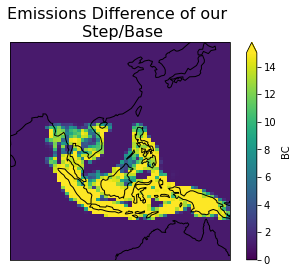

In [16]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree()})
((ds_emis.sel(run = 'delta')/ds_emis.sel(run = 'base'))).sum(dim = 'lev').isel(time = 0)['EmisBCPO_Total'].plot(ax = ax, transform = ccrs.PlateCarree(), vmax = 15, vmin = 0, cbar_kwargs = dict(label='BC'))
ax.coastlines()
ax.set_extent([80,150,-20,40])
plt.title('Emissions Difference of our \n Step/Base', fontsize = 16)

Text(0.5, 1.0, 'Concentration Difference of our \n Step - Base')

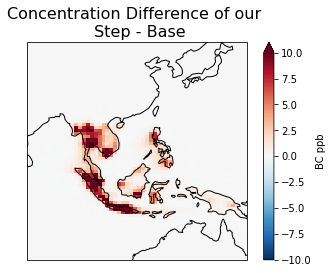

In [44]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree()})
((ds_conc.sel(run = 'delta') - ds_conc.sel(run = 'base'))*1e9).isel(lev = 0, time = 0)['BC_total'].plot(ax = ax, transform = ccrs.PlateCarree(), vmax = 10, vmin = -10, cmap = 'RdBu_r', cbar_kwargs = dict(label='BC ppb'))
ax.coastlines()
ax.set_extent([80,150,-20,40])
plt.title('Concentration Difference of our \n Step - Base', fontsize = 16)

Text(0.5, 1.0, 'Time Derivative Concentration \n Difference of our \n Step - Base')

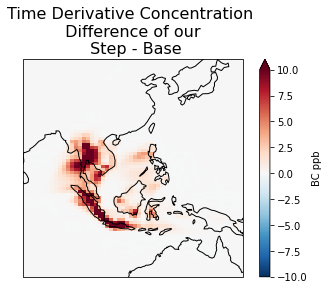

In [11]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree()})
((ds_conc.sel(run = 'delta') - ds_conc.sel(run = 'base'))*1e9).isel(lev = 0).diff(dim = 'time').isel(time = 0)['BC_total'].plot(ax = ax, transform = ccrs.PlateCarree(), vmax = 10, vmin = -10, cmap = 'RdBu_r', cbar_kwargs = dict(label='BC ppb'))
ax.coastlines()
ax.set_extent([80,150,-20,40])
plt.title('Time Derivative Concentration \n Difference of our \n Step - Base', fontsize = 16)

Text(0.5, 1.0, 'Emissions Difference of our \n Step - Base')

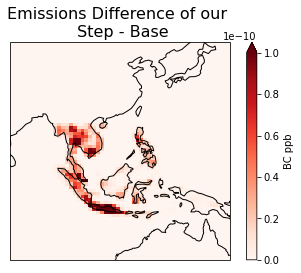

In [12]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree()})
(((ds_emis.sel(run = 'delta')-ds_emis.sel(run = 'base'))).sum(dim = 'lev').isel(time = 0)['EmisBCPO_Total']).plot(ax = ax, transform = ccrs.PlateCarree(), vmin = 0, vmax = 1e-10, cmap = 'Reds', cbar_kwargs = dict(label='BC ppb'))
ax.coastlines()
ax.set_extent([80,150,-20,40])
plt.title('Emissions Difference of our \n Step - Base', fontsize = 16)

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, "Green's Function")

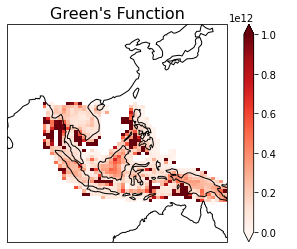

In [13]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection':ccrs.PlateCarree()})
(((ds_conc.sel(run = 'delta') - ds_conc.sel(run = 'base'))*1e9).isel(lev = 0, time = 0)['BC_total']/(
    ((ds_emis.sel(run = 'delta')-ds_emis.sel(run = 'base'))).sum(dim = 'lev').isel(time = 0)['EmisBCPO_Total'])).plot(ax = ax, transform = ccrs.PlateCarree(), vmin = 0, vmax = 1e12, cmap = 'Reds', cbar_kwargs = dict(label=' '))
ax.coastlines()
ax.set_extent([80,150,-20,40])
plt.title('Green\'s Function', fontsize = 16)

## Add height to data

In [17]:
height = pd.read_excel('gc_72_estimate.xlsx', index_col = 0)

In [18]:
height = height.reindex(index=height.index[::-1])

In [19]:
height_ds = height.diff().dropna().to_xarray().rename({'L':'lev'})
height_ds = height_ds.rename({'Altitude (km)':'dz'}) 
height_ds['dz']*=1e3 #convert to meters
height_ds['dz'].attrs = {'units':'m'}

In [20]:
#ds_emis = xr.merge([ds_emis, height_ds], join = 'inner')
ds_conc = xr.merge([ds_conc, height_ds], join = 'inner')

In [21]:
sec_day = 86400

## Define our Conc Difference and Initial Forcing

In [22]:
poll_name = 'BC_total'

In [23]:
ds_emis = ds_emis.isel(lev = -1) #select surface since we only have surface emissions

In [24]:
if global_mean == True:
    dc_dt = utils.calc_δc_δt_mean(ds_conc, poll_name)
    dc_dt = dc_dt.assign_coords(time = np.arange(.5,len(dc_dt['time'])+.5))
else:
    dc_dt = utils.calc_δc_δt(ds_conc, poll_name)
    dc_dt = dc_dt.assign_coords(time = np.arange(.5,len(dc_dt['time'])+.5))
    
    

dc_dt = dc_dt.rename({'time':'s'}) #tp should be s

f0 = (ds_emis['EmisBC_Total'].weighted(ds_emis['area'].fillna(0)).sum(dim = ['lat','lon']).sel(run = 'delta') - 
        ds_emis['EmisBC_Total'].weighted(ds_emis['area'].fillna(0)).sum(dim = ['lat','lon']).sel(run = 'base')).isel(time = 0).values #look into this a bit more regarding the t = 0

In [26]:
G = dc_dt/f0

# Save out the Green's function

In [27]:
G.to_netcdf(f'Outputs/G_{list(region.keys())[0]}_{month}_{poll_name}.nc4')

# Check the 2x conc vs a 2x emis times GF

In [55]:
dt = 1 #day

## Global Average Comparison

In [56]:
ds_emis = ds_emis.rename({'time':'tp'})

In [57]:
ds_emis = ds_emis.assign_coords(tp = np.arange(0,len(ds_emis['tp'])))

In [58]:
# trying to decide between weighting the sum of emissions

In [59]:
ds_emis_gmean = (ds_emis.sel(run = '2x')-
                 ds_emis.sel(run = 'base'))['EmisBC_Total'].weighted(
    (ds_emis['area'].fillna(0)).sel(run = 'base')).sum(dim = ['lat','lon']).compute()


In [61]:
out_mean = utils.convolve_global_mean(G.compute(), ds_emis_gmean)

Text(0.5, 0, 'Days')

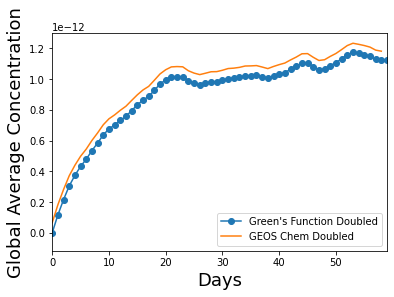

In [62]:
plt.plot(out_mean, label = 'Green\'s Function Doubled', marker = 'o')
plt.plot(utils.global_w_mean(ds_conc.sel(run = '2x').fillna(0), poll_name) - 
         utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name), label = 'GEOS Chem Doubled')
plt.legend()
plt.xlim(0,59)
plt.ylabel('Global Average Concentration', fontsize = 18)
plt.xlabel('Days', fontsize = 18)

## Location Average response 

In [23]:
ds_emis_loc = ds_emis.sel(lat = -5, lon = 100, method = 'nearest').sel(run = '2x')-ds_emis.sel(lat = -5, lon = 100, method = 'nearest').sel(run = 'base')

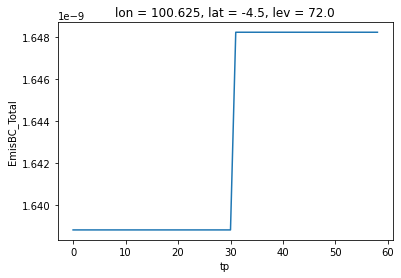

In [24]:
ds_emis_loc['EmisBC_Total'].plot()

In [25]:
G_loc = G.sel(lat = -5, lon = 100, method = 'nearest').isel(lev = 0)

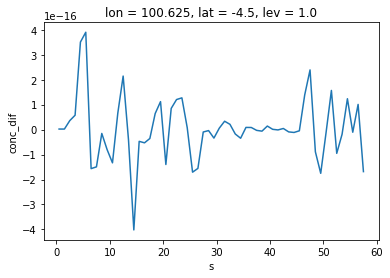

In [128]:
G_loc.plot()

In [27]:
out_mean = utils.convolve_global_mean(G_loc.compute(), ds_emis_gmean)

Text(0.5, 0, 'Days')

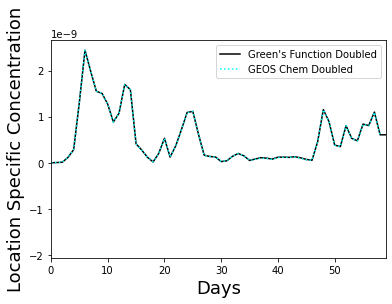

In [36]:
plt.plot(out_mean, label = 'Green\'s Function Doubled', linestyle = '-', color = 'black')
plt.plot((ds_conc.sel(lat = -5, lon = 100, method = 'nearest').isel(lev = 0).sel(run = '2x').fillna(0) - 
         ds_conc.sel(lat = -5, lon = 100, method = 'nearest').isel(lev = 0).sel(run = 'base').fillna(0))['BC_total'], 
         label = 'GEOS Chem Doubled', linestyle = ':', color = 'cyan')
plt.xlim([0,50])
plt.legend()
plt.xlim(0,59)
plt.ylabel('Location Specific Concentration', fontsize = 18)
plt.xlabel('Days', fontsize = 18)

## Spatial resolved 

In [35]:
f_2x = (ds_emis.sel(run = '2x')['EmisBC_Total'].weighted((ds_emis['area']).sel(run = '2x').isel(tp = 0)).sum(dim = ['lat','lon']).compute()-
    ds_emis.sel(run = 'base')['EmisBC_Total'].weighted((ds_emis['area']).sel(run = 'base').isel(tp = 0)).sum(dim = ['lat','lon']).compute())

In [36]:
comp_2x = (f_2x*G*dt).sum(dim = 'tp').compute()

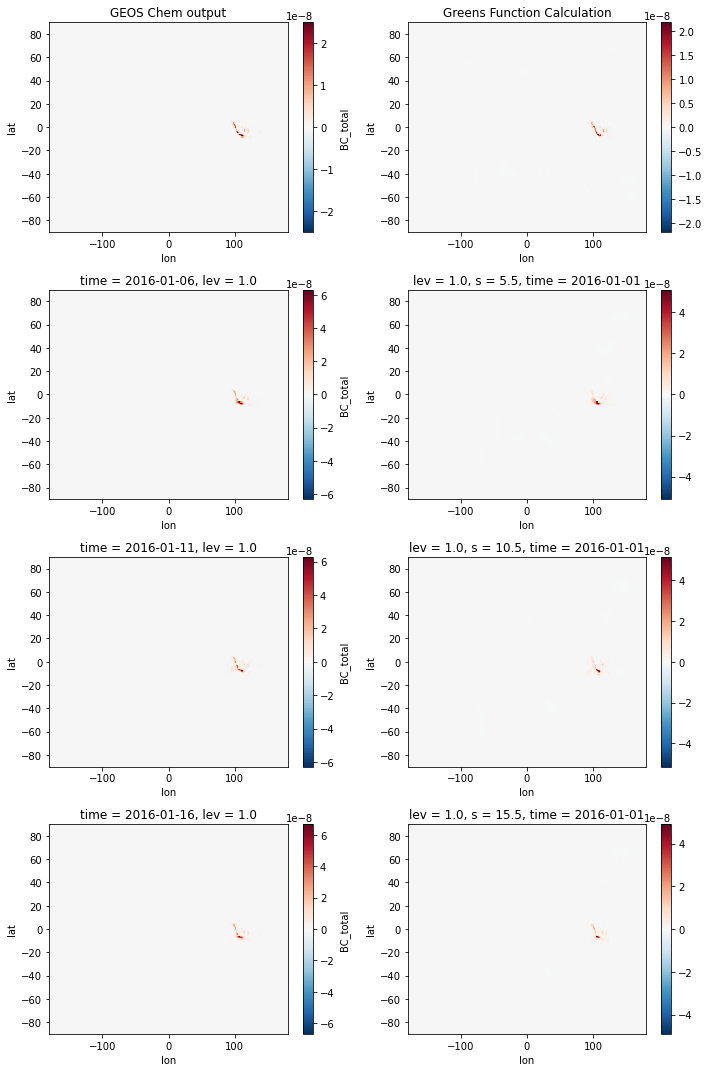

In [37]:
fig, axes = plt.subplots(4,2, figsize = [10,15])
for idx, s in enumerate([0,5,10,15]):
    (ds_conc.sel(run = '2x')-ds_conc.sel(run = 'base')).isel(time =s, lev = 0)[poll_name].plot(ax = axes[idx, 0])
    axes[0,0].set_title('GEOS Chem output')
    
    comp_2x.isel(s = s, lev = 0).plot(ax = axes[idx, 1])
    axes[0,1].set_title('Greens Function Calculation')
plt.tight_layout()